In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

from matplotlib.pylab import plt
from multiprocessing import Pool
import itertools
import numpy as np
import torch
from foltr.data.datasets import MqDataset
from foltr.client.click_simulate import NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL
from foltr.client.metrics import PrivatizedMaxRR, ExpectedMaxRR
from foltr.click_optimize import train_uniform
from foltr.client.rankers import LinearRanker, TwoLayerRanker
import scipy

seed = 7
torch.manual_seed(seed)
np.random.seed(seed)

all_click_models = [NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL]

In [2]:
data2007 = MqDataset.from_path("./data/MQ2007/", "./cache/")

Loading from cache file ././cache//51f3f297774a6b4f6b2ba8f09a067395.pkl
Loading from cache file ././cache//d8c769a90101f407935141adf73f446a.pkl
Loading from cache file ././cache//c254c204287eb73e457b5c1502fef110.pkl
Loading from cache file ././cache//d3bf468324b060a8c32c2abc1a7c9007.pkl
Loading from cache file ././cache//afd404899cd63a45bbc0bbb746f0adad.pkl
Loading from cache file ././cache//6b42f1207bc836b4b360a6cca9d175d2.pkl
Cached the array to ././cache//32085d34b138ade9b25b14ec2d85311c.pkl
Cached the array to ././cache//53f10952856498e3536c29c506df07b6.pkl
Cached the array to ././cache//16f628eaf4ac373ee0058b62b9cc503a.pkl
Cached the array to ././cache//7d828b414b547c72c97fa16e43ca20f1.pkl
Cached the array to ././cache//fcb8cabdbc0865259a9b9adfcbfa60fe.pkl
Cached the array to ././cache//823cae02167126f06352ad24b8873195.pkl
Cached the array to ././cache//22c6fa1e6d257d8385dc774fd7f44d73.pkl
Cached the array to ././cache//2ceb82b3956ccc66d6c4d10cfb4e2576.pkl
Cached the array to ././

In [3]:
linear_ranker_generator = lambda: LinearRanker(46)
two_layer_ranker_generator = lambda: TwoLayerRanker(46, 10)

common_params = dict(online_metric=PrivatizedMaxRR(0.9),
                     n_clients=2000,
                     sessions_budget=2000000, 
                     seed=seed,
                     sessions_per_feedback=4,
                     antithetic=True,
                     lr=1e-3,
                     noise_std=1e-2)

In [4]:
def do_task(task):
    fold_id, click_model, ranker_generator_id = task
    # workaround pickle
    ranker_generator = [linear_ranker_generator, two_layer_ranker_generator][ranker_generator_id]
    fold = data2007.folds[fold_id]        
    params = common_params.copy()
    params.update(dict(click_model=click_model, ranker_generator=ranker_generator))
    
    train_result = train_uniform(params, fold.train)
    return train_result
                            
tasks = itertools.product(range(len(data2007.folds)), 
                          [NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL],
                          range(2))
tasks = list(tasks)

n_cpu = min(80, len(tasks))
with Pool(n_cpu) as p:
    results = p.map(do_task, tasks)

In [5]:
click_model2sessions2trajectory = [{}, {}]
for task, trajectory in zip(tasks, results):
    fold_id, click_model, ranker_id = task
    click_model = click_model.name
    if click_model not in click_model2sessions2trajectory[ranker_id]:
        click_model2sessions2trajectory[ranker_id][click_model] = {}
    click_model2sessions2trajectory[ranker_id][click_model][fold_id] = trajectory

In [6]:
import json
with open('baselines.json', 'r') as f:
    baselines = json.loads(f.read())

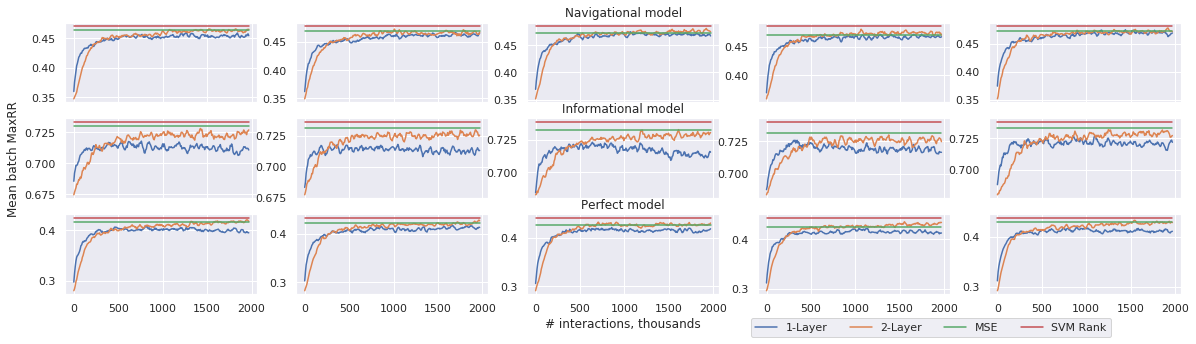

In [7]:
import seaborn as sns
from util import smoothen_trajectory
sns.set(style="darkgrid")
from pylab import rcParams
plt.close('all')
rcParams['figure.figsize'] = 20, 5
f, ax = plt.subplots(3, 5, sharex=True)

linear, two_layer = click_model2sessions2trajectory

m = common_params['sessions_per_feedback'] * common_params['n_clients']
for row, model in enumerate([NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL]):
    for fold_id, fold_trajectories in linear[model.name].items():
        a = ax[row, fold_id]
        ys = fold_trajectories.batch_metrics
        ys = smoothen_trajectory(ys, group_size=4)
        xs = np.array(range(len(ys))) * m * 1e-3
        a.plot(xs, ys, label=f"1-Layer")
        
        ys = two_layer[model.name][fold_id].batch_metrics
        ys = smoothen_trajectory(ys, group_size=4)
        xs = np.array(range(len(ys))) * m * 1e-3
        a.plot(xs, ys, label=f"2-Layer")
        
        lsq = baselines['lsq']['mq2007']['train'][model.name][fold_id]
        ys = np.array([lsq for _ in xs])
        a.plot(xs, ys, label=f"MSE") 
    

        
        svm_rank = baselines['svmrank']['mq2007']['train'][model.name][fold_id]
        ys = np.array([svm_rank for _ in xs])
        a.plot(xs, ys, label=f"SVM Rank") 

    ax[row, 2].set_title(f"{model.name} model")
ax[1, 0].set_ylabel("Mean batch MaxRR")
ax[2, 2].set_xlabel("# interactions, thousands")
ax[2, 0].legend(loc='lower center', bbox_to_anchor=(4.5, -0.6),
          ncol=4)

plt.show()
f.savefig(f'exp2-2007.png')

In [8]:
for click_model in [NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL]:
    per_fold_performace = {"linear": {"train": [], "test": []}, 
                           "two-layer":  {"train": [], "test": []}}
    
    for fold_id, fold in enumerate(data2007.folds):
        for data_name, data in [("test", fold.test), ("train", fold.train)]:
            linear_ranker = linear[click_model.name][fold_id].ranker
            linear_metric = ExpectedMaxRR(click_model).eval_ranker(linear_ranker, data)
            per_fold_performace["linear"][data_name].append(linear_metric)


            two_layer_ranker = two_layer[click_model.name][fold_id].ranker
            two_layer_metric = ExpectedMaxRR(click_model).eval_ranker(two_layer_ranker, data)
            per_fold_performace["two-layer"][data_name].append(two_layer_metric)

    svmrank_train = baselines['svmrank']['mq2007']['train'][click_model.name]
    svmrank_test = baselines['svmrank']['mq2007']['test'][click_model.name]
    
    lsq_train = baselines['lsq']['mq2007']['train'][click_model.name]
    lsq_test = baselines['lsq']['mq2007']['test'][click_model.name]
    
    
    print(click_model.name)
    p_train = scipy.stats.ttest_rel(per_fold_performace['two-layer']['train'], svmrank_train).pvalue

    print(f"\tMSE train {np.mean(lsq_train)}\n",
          f"\tSVM Rank train {np.mean(svmrank_train)}\n",
          f"\tLinear train {np.mean(per_fold_performace['linear']['train'])}\n", 
          f"\tTwo layer train: {np.mean(per_fold_performace['two-layer']['train'])}\n",
          f"\t\tp value vs SVMRank {p_train}")
    

          
    p_test = scipy.stats.ttest_rel(per_fold_performace['two-layer']['test'], svmrank_test).pvalue
    print(f"\tMSE test {np.mean(lsq_test)}\n",
          f"\tSVM Rank test {np.mean(svmrank_test)}\n",
          f"\tLinear test {np.mean(per_fold_performace['linear']['test'])}\n", 
          f"\tTwo layer test: {np.mean(per_fold_performace['two-layer']['test'])}\n",
          f"\t\tp value vs SVMRank {p_test}")

Navigational
	MSE train 0.46997444652654546
 	SVM Rank train 0.47995541189335544
 	Linear train 0.4674642718539331
 	Two layer train: 0.4761671326823406
 		p value vs SVMRank 0.030356115172885768
	MSE test 0.46173335784413716
 	SVM Rank test 0.4770294120645947
 	Linear test 0.46401340827949245
 	Two layer test: 0.4668327711203378
 		p value vs SVMRank 0.1051161361827331
Informational
	MSE train 0.7315838662804092
 	SVM Rank train 0.7370821493548693
 	Linear train 0.7151061766187248
 	Two layer train: 0.7313642539233984
 		p value vs SVMRank 0.007315968732648612
	MSE test 0.7272013412868448
 	SVM Rank test 0.7362392531949935
 	Linear test 0.7135333715077715
 	Two layer test: 0.7278146575015036
 		p value vs SVMRank 0.0914983255651173
Perfect
	MSE train 0.4244622389417311
 	SVM Rank train 0.43582326160538437
 	Linear train 0.4115469282396166
 	Two layer train: 0.43358808277857064
 		p value vs SVMRank 0.1026717420097586
	MSE test 0.4149006079720328
 	SVM Rank test 0.43223461832899474
 	L